
# 7-8，DIEN网络

阿里妈妈在CTR预估领域有3篇比较有名的文章。

2017年的深度兴趣网络, DIN(DeepInterestNetwork)。 

2018年的深度兴趣演化网络, DIEN(DeepInterestEvolutionNetWork)。

2019年的深度会话兴趣网络, DSIN(DeepSessionInterestNetWork)。

这3篇文章的主要思想和相互关系用一句话分别概括如下：

第1篇DIN说，用户的行为日志中只有一部分和当前候选广告有关。可以利用Attention机制从用户行为日志中建模出和当前候选广告相关的用户兴趣表示。我们试过涨点了嘻嘻嘻。

第2篇DIEN说，用户最近的行为可能比较远的行为更加重要。可以用循环神经网络GRU建模用户兴趣随时间的演化。我们试过也涨点了嘿嘿嘿。

第3篇DSIN说，用户在同一次会话中的行为高度相关，在不同会话间的行为则相对独立。可以把用户行为日志按照时间间隔分割成会话并用SelfAttention机制建模它们之间的相互作用。我们试过又涨点了哈哈哈。

参考材料：

* DIEN论文： https://arxiv.org/pdf/1809.03672.pdf 

* DIN+DIEN，机器学习唯一指定涨点技Attention： https://zhuanlan.zhihu.com/p/431131396

* 从DIN到DIEN看阿里CTR算法的进化脉络： https://zhuanlan.zhihu.com/p/78365283

* 代码实现参考： https://github.com/GitHub-HongweiZhang/prediction-flow

上一篇文章我们介绍了DIN, 本篇文章我们介绍DIEN。

DIEN这篇文章的主要创新之处有3点：

* 一是引入GRU来从用户行为日志序列中自然地抽取每个行为日志对应的用户兴趣表示(兴趣抽取层)。

* 二是设计了一个辅助loss层，通过做一个辅助任务(区分真实的用户历史点击行为和负采样的非用户点击行为)来强化用户兴趣表示的学习。

* 三是将注意力机制和GRU结构结合起来(AUGRU: Attention UPdate GRU)，来建模用户兴趣的时间演化得到最终的用户表示(兴趣演化层)。

其中引入辅助Loss的技巧是神经网络涨点非常通用的一种高级技巧，值得我们学习。


<br>

<font color="red">
 
公众号 **算法美食屋** 回复关键词：**pytorch**， 获取本项目源码和所用数据集百度云盘下载链接。
    
</font> 


## 一，DIEN原理解析

DIEN的主要出发点是，用户最近的行为可能比较远的行为更加重要。可以用循环神经网络GRU建模用户兴趣随时间的演化。

DIEN选择的是不容易梯度消失且较快的GRU。

![](https://tva1.sinaimg.cn/large/e6c9d24egy1h3x1brptqij20k10b8jsp.jpg)

### 1, 兴趣抽取层

图中的 $b(t)$ 是用户的行为序列，而 $e(t)$是对应的embedding。随着自然发生的顺序， $e(t)$被输入GRU中，这就是兴趣抽取层。

也是DIEN的第一条创新：引入GRU来从用户行为日志序列中自然地抽取每个行为日志对应的用户兴趣表示(兴趣抽取层)。



### 2，辅助loss 

如果忽略上面的AUGRU环节，GRU中的隐状态 $h(t)$就应该成为用户的行为序列最后的表示。

如果直接就这样做，也不是不可以，但是$h(t)$学习到的东西可能不是我们想要的用户兴趣表示，或者说$h(t)$很难学习到有意义的信息。

因为$h(t)$ 的迭代经过了很多步，然后还要和其他特征做拼接，然后还要经过MLP，最后才得到输出去计算Loss。

这样的结果就是最后来了一个正样本或负样本，反向传播很难归因到 $h(t)$ 上。

基于此DIEN给出了第二个要点：使用辅助Loss来强化$h(t)$的学习。

我们来看看这个辅助Loss是怎么做的？这里设计了一个辅助任务，使用$h(t)$来区分真实的用户历史点击行为和负采样的非用户点击行为。

由于$h(t)$ 代表着 t 时刻的用户兴趣表示，我们可以用它来预测 t+1时刻的广告用户是否点击。

因为用户行为日志中都是用户点击过的广告(正样本, $e(t)$)，所以我们可以从全部的广告中给用户采样同样数量的用户没有点击过的广告作为负样本$e'(t)$。

结合$h(t)$和 $e(t)$, $e'(t)$作为输入, 我们可以做一个二分类的辅助任务。

这个辅助任务给$h(t)$在每个t时刻都提供了一个监督信号，使得$h(t)$能够更好地成为用户兴趣的抽取表示。

真实应用场合下，你把开始的输入和最后的要求告诉网络，它就能给你一个好的结果的情况非常少。

大多数时候是需要你去控制每一步的输入输出，每一步的loss才能防止网络各种偷懒作弊。

辅助loss能够使得网络更受控制，向我们需要的方向发展，非常建议大家在实际业务中多试试辅助loss。



### 3，兴趣演化层

通过兴趣抽取层和辅助loss，我们得到了每个t时刻用户的一般兴趣表示。

注意这个兴趣表示是一般性的，还没有和我们的候选广告做Attention关联。

在DIN中，我们通过Attention机制构建了和候选广告相关的用户兴趣表示。

而在DIEN中，我们希望建立的是和和候选广告相关，并且和时间演化相关的用户兴趣表示。

DIEN通过结合Attention机制和GRU结构来做到这一点，这就是第三点创新AUGRU : Attention UPdate Gate GRU。

下面我们进行详细讲解。

一般地，各种RNN序列模型层(SimpleRNN,GRU,LSTM等)可以用函数表示如下:

$$h_t = f(h_{t-1},i_t)$$

这个公式的含义是：t时刻循环神经网络的输出向量$h_t$由t-1时刻的输出向量$h_{t-1}$和t时刻的输入$i_t$变换而来。

为了结合Attention机制和GRU结构，我们需要设计这样的一个有三种输入的序列模型

$$h_t = g(h_{t-1},i_t, a_t)$$

这里的$a_t$是 t时刻的用户兴趣表示输入 $i_t$和候选广告计算出的attention 得分，是个标量。

我们先看看 GRU的 具体函数形式： 

$$
\begin{align}
u_t &= \sigma(W^u i_t + U^u h_{t-1} + b^u) \tag{1} \\
r_t &= \sigma(W^r i_t + U^r h_{t-1} + b^r) \tag{2} \\
n_t &= \tanh(W^n i_t + r_t \circ U^n h_{t-1} + b^n) \tag{3} \\
h_t &= h_{t-1} - u_t 	\circ h_{t-1} + u_t \circ n_t \tag{4} \\
\end{align}
$$


公式中的小圈表示哈达玛积，也就是两个向量逐位相乘。

其中(1)式和(2)式计算的是更新门$u_t$和重置门$r_t$，是两个长度和$h_t$相同的向量。

更新门用于控制每一步$h_t$被更新的比例，更新门越大，$h_t$更新幅度越大。

重置门用于控制更新候选向量$n_t$中前一步的状态$h_{t-1}$被重新放入的比例，重置门越大，更新候选向量中$h_{t-1}$被重新放进来的比例越大。

注意到(4)式 实际上和ResNet的残差结构是相似的，都是 f(x) = x + g(x) 的形式，可以有效地防止长序列学习反向传播过程中梯度消失问题。

如何在GRU的基础上把attention得分融入进来呢？有以下一些非常自然的想法：

* 1， 用$a_t$缩放输入$i_t$, 这就是AIGRU: Attention Input GRU。其含义是相关性高的在输入端进行放大。

* 2， 用$a_t$代替GRU的更新门，这就是AGRU: Attention based GRU。其含义是用直接用相关性作为更新幅度。

* 3， 用$a_t$缩放GRU的更新门$u_t$，这就是AUGRU:  Attention Update Gate GRU。其含义是用用相关性缩放更新幅度。

AIGRU实际上并没有改变GRU的结构，只是改变了其输入，这种方式对Attention的使用比较含蓄，我把每个历史广告的相关性强弱通过输入告诉GRU，GRU你就给我好好学吧，希望你把相关性强的广告多长点到脑子里。但是这种方式效果不是很理想，即使是相关性为0的历史广告，也会对进行更新。

AGRU是改变了GRU的结构的，并且对Attention的使用非常激进，完全删掉了GRU原有的的更新门，GRU你的脑子归Attention管了，遇到相关性高的广告，一定大大地记上一笔。不过AGRU也有一个缺陷，那就是Attention得分实际上是个标量，无法反应不同维度的差异。

AUGRU也是改变了GRU的结构的，并且对Attention的使用比较折衷，让Attention缩放GRU原有的更新幅度。GRU我给你找了个搭档Attention，你更新前先问问它，你两一起决定该迈多大的步子吧。

DIEN论文中通过对比实验发现AUGRU的效果最好。

我们看看AUGRU的核心实现代码。基本上和公式是一致的，应用了F.linear函数来实现矩阵乘法和加偏置。


In [1]:
import torch 
from torch import nn 

class AttentionUpdateGateGRUCell(nn.Module):
    def __init__(self, input_size, hidden_size, bias=True):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias
        # (Wu|Wr|Wn)
        self.weight_ih = nn.Parameter(
            torch.Tensor(3 * hidden_size, input_size))
        # (Uu|Ur|Un)
        self.weight_hh = nn.Parameter(
            torch.Tensor(3 * hidden_size, hidden_size))
        if bias:
            # (b_iu|b_ir|b_in)
            self.bias_ih = nn.Parameter(torch.Tensor(3 * hidden_size))
            # (b_hu|b_hr|b_hn)
            self.bias_hh = nn.Parameter(torch.Tensor(3 * hidden_size))
        else:
            self.register_parameter('bias_ih', None)
            self.register_parameter('bias_hh', None)
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1.0 / (self.hidden_size)**0.5
        for weight in self.parameters():
            nn.init.uniform_(weight, -stdv, stdv)
            
    def forward(self, x, hx, att_score):
        gi = F.linear(x, self.weight_ih, self.bias_ih)
        gh = F.linear(hx, self.weight_hh, self.bias_hh)
        i_r, i_u, i_n = gi.chunk(3, 1)
        h_r, h_u, h_n = gh.chunk(3, 1)

        resetgate = torch.sigmoid(i_r + h_r)
        updategate = torch.sigmoid(i_u + h_u)
        newgate = torch.tanh(i_n + resetgate * h_n)

        updategate = att_score.view(-1, 1) * updategate
        hy = (1-updategate)*hx +  updategate*newgate

        return hy


## 二，DIEN的pytorch实现

下面是一个DIEN模型的完整pytorch实现。许多代码和DIN的实现是一样的。

这里的AttentionGroup类用来建立候选广告属性，历史广告属性，以及负采样的广告属性的pair关系。



In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F 
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from collections import OrderedDict

class MaxPooling(nn.Module):
    def __init__(self, dim):
        super(MaxPooling, self).__init__()
        self.dim = dim

    def forward(self, input):
        return torch.max(input, self.dim)[0]


class SumPooling(nn.Module):
    def __init__(self, dim):
        super(SumPooling, self).__init__()
        self.dim = dim

    def forward(self, input):
        return torch.sum(input, self.dim)

class Dice(nn.Module):
    """
    The Data Adaptive Activation Function in DIN, a generalization of PReLu.
    """
    def __init__(self, emb_size, dim=2, epsilon=1e-8):
        super(Dice, self).__init__()
        assert dim == 2 or dim == 3

        self.bn = nn.BatchNorm1d(emb_size, eps=epsilon)
        self.sigmoid = nn.Sigmoid()
        self.dim = dim
        
        # wrap alpha in nn.Parameter to make it trainable
        self.alpha = nn.Parameter(torch.zeros((emb_size,))) if self.dim == 2 else nn.Parameter(
            torch.zeros((emb_size, 1)))


    def forward(self, x):
        assert x.dim() == self.dim
        if self.dim == 2:
            x_p = self.sigmoid(self.bn(x))
            out = self.alpha * (1 - x_p) * x + x_p * x
        else:
            x = torch.transpose(x, 1, 2)
            x_p = self.sigmoid(self.bn(x))
            out = self.alpha * (1 - x_p) * x + x_p * x
            out = torch.transpose(out, 1, 2)
        return out

    
class Identity(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, x):
        return x
    
def get_activation_layer(name, hidden_size=None, dice_dim=2):
    name = name.lower()
    name_dict = {x.lower():x for x in dir(nn) if '__' not in x and 'Z'>=x[0]>='A'}
    if name=="linear":
        return Identity()
    elif name=="dice":
        assert dice_dim
        return Dice(hidden_size, dice_dim)
    else:
        assert name in name_dict, f'activation type {name} not supported!'
        return getattr(nn,name_dict[name])()
    
def init_weights(model):
    if isinstance(model, nn.Linear):
        if model.weight is not None:
            nn.init.kaiming_uniform_(model.weight.data)
        if model.bias is not None:
            nn.init.normal_(model.bias.data)
    elif isinstance(model, (nn.BatchNorm1d,nn.BatchNorm2d,nn.BatchNorm3d)):
        if model.weight is not None:
            nn.init.normal_(model.weight.data, mean=1, std=0.02)
        if model.bias is not None:
            nn.init.constant_(model.bias.data, 0)
    else:
        pass


class MLP(nn.Module):
    def __init__(self, input_size, hidden_layers,
                 dropout=0.0, batchnorm=True, activation='relu'):
        super(MLP, self).__init__()
        modules = OrderedDict()
        previous_size = input_size
        for index, hidden_layer in enumerate(hidden_layers):
            modules[f"dense{index}"] = nn.Linear(previous_size, hidden_layer)
            if batchnorm:
                modules[f"batchnorm{index}"] = nn.BatchNorm1d(hidden_layer)
            if activation:
                modules[f"activation{index}"] = get_activation_layer(activation,hidden_layer,2)
            if dropout:
                modules[f"dropout{index}"] = nn.Dropout(dropout)
            previous_size = hidden_layer
        self.mlp = nn.Sequential(modules)

    def forward(self, x):
        return self.mlp(x)


class AttentionGRUCell(nn.Module):
    def __init__(self, input_size, hidden_size, bias=True):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias
        # (Wr|Wn)
        self.weight_ih = nn.Parameter(
            torch.Tensor(2 * hidden_size, input_size))
        # (Ur|Un)
        self.weight_hh = nn.Parameter(
            torch.Tensor(2 * hidden_size, hidden_size))
        if bias:
            # (b_ir|b_in)
            self.bias_ih = nn.Parameter(torch.Tensor(2 * hidden_size))
            # (b_hr|b_hn)
            self.bias_hh = nn.Parameter(torch.Tensor(2 * hidden_size))
        else:
            self.register_parameter('bias_ih', None)
            self.register_parameter('bias_hh', None)
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1.0 / (self.hidden_size)**0.5
        for weight in self.parameters():
            nn.init.uniform_(weight, -stdv, stdv)

    def forward(self, x, hx, att_score):

        gi = F.linear(x, self.weight_ih, self.bias_ih)
        gh = F.linear(hx, self.weight_hh, self.bias_hh)
        i_r, i_n = gi.chunk(2, 1)
        h_r, h_n = gh.chunk(2, 1)

        resetgate = torch.sigmoid(i_r + h_r)
        newgate = torch.tanh(i_n + resetgate * h_n)
        att_score = att_score.view(-1, 1)
        hy = (1. - att_score) * hx + att_score * newgate
        
        return hy


class AttentionUpdateGateGRUCell(nn.Module):
    def __init__(self, input_size, hidden_size, bias=True):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias
        # (Wu|Wr|Wn)
        self.weight_ih = nn.Parameter(
            torch.Tensor(3 * hidden_size, input_size))
        # (Uu|Ur|Un)
        self.weight_hh = nn.Parameter(
            torch.Tensor(3 * hidden_size, hidden_size))
        if bias:
            # (b_iu|b_ir|b_in)
            self.bias_ih = nn.Parameter(torch.Tensor(3 * hidden_size))
            # (b_hu|b_hr|b_hn)
            self.bias_hh = nn.Parameter(torch.Tensor(3 * hidden_size))
        else:
            self.register_parameter('bias_ih', None)
            self.register_parameter('bias_hh', None)
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1.0 / (self.hidden_size)**0.5
        for weight in self.parameters():
            nn.init.uniform_(weight, -stdv, stdv)
            
    def forward(self, x, hx, att_score):
        gi = F.linear(x, self.weight_ih, self.bias_ih)
        gh = F.linear(hx, self.weight_hh, self.bias_hh)
        i_u,i_r, i_n = gi.chunk(3, 1)
        h_u,h_r, h_n = gh.chunk(3, 1)

        updategate = torch.sigmoid(i_u + h_u)
        resetgate = torch.sigmoid(i_r + h_r)
        newgate = torch.tanh(i_n + resetgate * h_n)

        updategate = att_score.view(-1, 1) * updategate
        hy = (1-updategate)*hx +  updategate*newgate

        return hy



class DynamicGRU(nn.Module):
    def __init__(self, input_size, hidden_size, bias=True, gru_type='AGRU'):
        super(DynamicGRU, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        if gru_type == 'AGRU':
            self.rnn = AttentionGRUCell(input_size, hidden_size, bias)
        elif gru_type == 'AUGRU':
            self.rnn = AttentionUpdateGateGRUCell(
                input_size, hidden_size, bias)

    def forward(self, x, att_scores, hx=None):
        is_packed_input = isinstance(x, nn.utils.rnn.PackedSequence)
        if not is_packed_input:
            raise NotImplementedError(
                "DynamicGRU only supports packed input")

        is_packed_att_scores = isinstance(att_scores, nn.utils.rnn.PackedSequence)
        if not is_packed_att_scores:
            raise NotImplementedError(
                "DynamicGRU only supports packed att_scores")

        x, batch_sizes, sorted_indices, unsorted_indices = x
        att_scores, _, _, _ = att_scores

        max_batch_size = batch_sizes[0]
        max_batch_size = int(max_batch_size)

        if hx is None:
            hx = torch.zeros(
                max_batch_size, self.hidden_size,
                dtype=x.dtype, device=x.device)

        outputs = torch.zeros(
            x.size(0), self.hidden_size,
            dtype=x.dtype, device=x.device)

        begin = 0
        for batch in batch_sizes:
            new_hx = self.rnn(
                x[begin: begin + batch],
                hx[0:batch],
                att_scores[begin: begin + batch])
            outputs[begin: begin + batch] = new_hx
            hx = new_hx
            begin += batch

        return nn.utils.rnn.PackedSequence(
            outputs, batch_sizes, sorted_indices, unsorted_indices)
    

class Attention(nn.Module):
    def __init__(
            self,
            input_size,
            hidden_layers,
            dropout=0.0,
            batchnorm=True,
            activation='prelu',
            return_scores=False):
        
        super().__init__()
        self.return_scores = return_scores
        
        self.mlp = MLP(
            input_size=input_size * 4,
            hidden_layers=hidden_layers,
            dropout=dropout,
            batchnorm=batchnorm,
            activation=activation)
        self.fc = nn.Linear(hidden_layers[-1], 1)

    def forward(self, query, keys, keys_length):
        """
        Parameters
        ----------
        query: 2D tensor, [Batch, Hidden]
        keys: 3D tensor, [Batch, Time, Hidden]
        keys_length: 1D tensor, [Batch]

        Returns
        -------
        outputs: 2D tensor, [Batch, Hidden]
        """
        batch_size, max_length, dim = keys.size()

        query = query.unsqueeze(1).expand(-1, max_length, -1)

        din_all = torch.cat(
            [query, keys, query - keys, query * keys], dim=-1)

        din_all = din_all.view(batch_size * max_length, -1)

        outputs = self.mlp(din_all)

        outputs = self.fc(outputs).view(batch_size, max_length)  # [B, T]

        # Scale
        outputs = outputs / (dim ** 0.5)

        # Mask
        mask = (torch.arange(max_length, device=keys_length.device).repeat(
            batch_size, 1) < keys_length.view(-1, 1))
        outputs[~mask] = -np.inf

        # Activation
        outputs = F.softmax(outputs, dim=1)  #DIN uses sigmoid,DIEN uses softmax; [B, T]

        if not self.return_scores:
            # Weighted sum
            outputs = torch.matmul(
                outputs.unsqueeze(1), keys).squeeze()  # [B, H]
        return outputs 
    
class AuxiliaryNet(nn.Module):
    def __init__(self, input_size, hidden_layers, activation='sigmoid'):
        super().__init__()
        modules = OrderedDict()
        previous_size = input_size
        for index, hidden_layer in enumerate(hidden_layers):
            modules[f"dense{index}"] = nn.Linear(previous_size, hidden_layer)
            if activation:
                modules[f"activation{index}"] = get_activation_layer(activation)
            previous_size = hidden_layer
        modules["final_layer"] = nn.Linear(previous_size, 1)
        self.mlp = nn.Sequential(modules)

    def forward(self, x):
        return torch.sigmoid(self.mlp(x))


class Interest(nn.Module):
    SUPPORTED_GRU_TYPE = ['GRU', 'AIGRU', 'AGRU', 'AUGRU']

    def __init__(
            self,
            input_size,
            gru_type='AUGRU',
            gru_dropout=0.0,
            att_hidden_layers=[80, 40],
            att_dropout=0.0,
            att_batchnorm=True,
            att_activation='prelu',
            use_negsampling=False):
        super(Interest, self).__init__()
        if gru_type not in Interest.SUPPORTED_GRU_TYPE:
            raise NotImplementedError(f"gru_type: {gru_type} is not supported")

        self.gru_type = gru_type
        self.use_negsampling = use_negsampling

        self.interest_extractor = nn.GRU(
            input_size=input_size,
            hidden_size=input_size,
            batch_first=True,
            bidirectional=False)

        if self.use_negsampling:
            self.auxiliary_net = AuxiliaryNet(
                input_size * 2, hidden_layers=[100, 50])

        if gru_type == 'GRU':
            self.attention = Attention(
                input_size=input_size,
                hidden_layers=att_hidden_layers,
                dropout=att_dropout,
                batchnorm=att_batchnorm,
                activation=att_activation)
            
            self.interest_evolution = nn.GRU(
                input_size=input_size,
                hidden_size=input_size,
                batch_first=True,
                bidirectional=False)
                
        elif gru_type == 'AIGRU':
            self.attention = Attention(
                input_size=input_size,
                hidden_layers=att_hidden_layers,
                dropout=att_dropout,
                batchnorm=att_batchnorm,
                activation=att_activation,
                return_scores=True)

            self.interest_evolution = nn.GRU(
                input_size=input_size,
                hidden_size=input_size,
                batch_first=True,
                bidirectional=False)
            
        elif gru_type == 'AGRU' or gru_type == 'AUGRU':
            self.attention = Attention(
                input_size=input_size,
                hidden_layers=att_hidden_layers,
                dropout=att_dropout,
                batchnorm=att_batchnorm,
                activation=att_activation,
                return_scores=True)

            self.interest_evolution = DynamicGRU(
                input_size=input_size,
                hidden_size=input_size,
                gru_type=gru_type)

    @staticmethod
    def get_last_state(states, keys_length):
        # states [B, T, H]
        batch_size, max_seq_length, hidden_size = states.size()

        mask = (torch.arange(max_seq_length, device=keys_length.device).repeat(
            batch_size, 1) == (keys_length.view(-1, 1) - 1))

        return states[mask]

    def cal_auxiliary_loss(
            self, states, click_seq, noclick_seq, keys_length):
        # states [B, T, H]
        # click_seq [B, T, H]
        # noclick_seq [B, T, H]
        # keys_length [B]
        batch_size, max_seq_length, embedding_size = states.size()

        mask = (torch.arange(max_seq_length, device=states.device).repeat(
            batch_size, 1) < keys_length.view(-1, 1)).float()

        click_input = torch.cat([states, click_seq], dim=-1)
        noclick_input = torch.cat([states, noclick_seq], dim=-1)
        embedding_size = embedding_size * 2

        click_p = self.auxiliary_net(
            click_input.view(
                batch_size * max_seq_length, embedding_size)).view(
                    batch_size, max_seq_length)[mask > 0].view(-1, 1)
        click_target = torch.ones(
            click_p.size(), dtype=torch.float, device=click_p.device)

        noclick_p = self.auxiliary_net(
            noclick_input.view(
                batch_size * max_seq_length, embedding_size)).view(
                    batch_size, max_seq_length)[mask > 0].view(-1, 1)
        noclick_target = torch.zeros(
            noclick_p.size(), dtype=torch.float, device=noclick_p.device)

        loss = F.binary_cross_entropy(
            torch.cat([click_p, noclick_p], dim=0),
            torch.cat([click_target, noclick_target], dim=0))

        return loss

    def forward(self, query, keys, keys_length, neg_keys=None):
        """
        Parameters
        ----------
        query: 2D tensor, [Batch, Hidden]
        keys: 3D tensor, [Batch, Time, Hidden]
        keys_length: 1D tensor, [Batch]
        neg_keys: 3D tensor, [Batch, Time, Hidden]

        Returns
        -------
        outputs: 2D tensor, [Batch, Hidden]
        """
        batch_size, max_length, dim = keys.size()

        packed_keys = pack_padded_sequence(
            keys,
            lengths=keys_length.squeeze().cpu(),
            batch_first=True,
            enforce_sorted=False)

        packed_interests, _ = self.interest_extractor(packed_keys)

        aloss = None
        if (self.gru_type != 'GRU') or self.use_negsampling:
            interests, _ = pad_packed_sequence(
                packed_interests,
                batch_first=True,
                padding_value=0.0,
                total_length=max_length)

            if self.use_negsampling:
                aloss = self.cal_auxiliary_loss(
                    interests[:, :-1, :],
                    keys[:, 1:, :],
                    neg_keys[:, 1:, :],
                    keys_length - 1)

        if self.gru_type == 'GRU':
            packed_interests, _ = self.interest_evolution(packed_interests)

            interests, _ = pad_packed_sequence(
                packed_interests,
                batch_first=True,
                padding_value=0.0,
                total_length=max_length)

            outputs = self.attention(query, interests, keys_length)

        elif self.gru_type == 'AIGRU':
            # attention
            scores = self.attention(query, interests, keys_length)
            interests = interests * scores.unsqueeze(-1)

            packed_interests = pack_padded_sequence(
                interests,
                lengths=keys_length.squeeze().cpu(),
                batch_first=True,
                enforce_sorted=False)
            _, outputs = self.interest_evolution(packed_interests)
            outputs = outputs.squeeze()

        elif self.gru_type == 'AGRU' or self.gru_type == 'AUGRU':
            # attention
            scores = self.attention(query, interests, keys_length)

            packed_interests = pack_padded_sequence(
                interests,
                lengths=keys_length.squeeze().cpu(),
                batch_first=True,
                enforce_sorted=False)

            packed_scores = pack_padded_sequence(
                scores,
                lengths=keys_length.squeeze().cpu(),
                batch_first=True,
                enforce_sorted=False)

            outputs, _ = pad_packed_sequence(
                self.interest_evolution(
                    packed_interests, packed_scores), batch_first=True)
            # pick last state
            outputs = Interest.get_last_state(
                outputs, keys_length.squeeze())

        return outputs, aloss
    
class AttentionGroup(object):
    def __init__(self, name, pairs,
                 hidden_layers, activation='dice', att_dropout=0.0,
                 gru_type='AUGRU', gru_dropout=0.0):
        self.name = name
        self.pairs = pairs
        self.hidden_layers = hidden_layers
        self.activation = activation
        self.att_dropout = att_dropout
        self.gru_type = gru_type
        self.gru_dropout = gru_dropout

        self.related_feature_names = set()
        self.neg_feature_names = set()
        for pair in pairs:
            self.related_feature_names.add(pair['ad'])
            self.related_feature_names.add(pair['pos_hist'])
            if 'neg_hist' in pair:
                self.related_feature_names.add(pair['neg_hist'])
                self.neg_feature_names.add(pair['neg_hist'])

    def is_attention_feature(self, feature_name):
        if feature_name in self.related_feature_names:
            return True
        return False

    def is_neg_sampling_feature(self, feature_name):
        if feature_name in self.neg_feature_names:
            return True
        return False

    @property
    def pairs_count(self):
        return len(self.pairs)
    
class DIEN(nn.Module):
    def __init__(self, num_features,cat_features,seq_features, 
                 cat_nums,embedding_size, attention_groups,
                 mlp_hidden_layers, mlp_activation='prelu', mlp_dropout=0.0,
                 use_negsampling = False,
                 d_out = 1
                 ):
        super().__init__()
        self.num_features = num_features
        self.cat_features = cat_features
        self.seq_features = seq_features
        self.cat_nums = cat_nums 
        self.embedding_size = embedding_size
        
        self.attention_groups = attention_groups
        
        self.mlp_hidden_layers = mlp_hidden_layers
        self.mlp_activation = mlp_activation
        self.mlp_dropout = mlp_dropout
        
        self.d_out = d_out
        self.use_negsampling = use_negsampling
        
        #embedding
        self.embeddings = OrderedDict()
        for feature in self.cat_features+self.seq_features:
            self.embeddings[feature] = nn.Embedding(
                self.cat_nums[feature], self.embedding_size, padding_idx=0)
            self.add_module(f"embedding:{feature}",self.embeddings[feature])

        self.sequence_poolings = OrderedDict()
        self.attention_poolings = OrderedDict()
        total_embedding_sizes = 0
        for feature in self.cat_features:
            total_embedding_sizes += self.embedding_size
        for feature in self.seq_features:
            if not self.is_neg_sampling_feature(feature):
                total_embedding_sizes += self.embedding_size
        
        #sequence_pooling
        for feature in self.seq_features:
            if not self.is_attention_feature(feature):
                self.sequence_poolings[feature] = MaxPooling(1)
                self.add_module(f"pooling:{feature}",self.sequence_poolings[feature])

        #attention_pooling
        for attention_group in self.attention_groups:
            self.attention_poolings[attention_group.name] = (
                self.create_attention_fn(attention_group))
            self.add_module(f"attention_pooling:{attention_group.name}",
                self.attention_poolings[attention_group.name])

        total_input_size = total_embedding_sizes+len(self.num_features)
        
        self.mlp = MLP(
            total_input_size,
            mlp_hidden_layers,
            dropout=mlp_dropout, batchnorm=True, activation=mlp_activation)
        
        self.final_layer = nn.Linear(mlp_hidden_layers[-1], self.d_out)
        self.apply(init_weights)
        
        
    def forward(self, x):
        final_layer_inputs = list()

        # linear
        number_inputs = list()
        for feature in self.num_features:
            number_inputs.append(x[feature].view(-1, 1))

        embeddings = OrderedDict()
        for feature in self.cat_features:
            embeddings[feature] = self.embeddings[feature](x[feature])

        for feature in self.seq_features:
            if not self.is_attention_feature(feature):
                embeddings[feature] = self.sequence_poolings[feature](
                    self.embeddings[feature](x[feature]))

        auxiliary_losses = []
        for attention_group in self.attention_groups:
            query = torch.cat(
                [embeddings[pair['ad']]
                 for pair in attention_group.pairs],
                dim=-1)
            pos_hist = torch.cat(
                [self.embeddings[pair['pos_hist']](
                    x[pair['pos_hist']]) for pair in attention_group.pairs],
                dim=-1)
            
            #hist_length = torch.sum(hist>0,axis=1)
            keys_length = torch.min(torch.cat(
                [torch.sum(x[pair['pos_hist']]>0,axis=1).view(-1, 1)
                 for pair in attention_group.pairs],
                dim=-1), dim=-1)[0]
    
            neg_hist = None
            if self.use_negsampling:
                neg_hist = torch.cat(
                    [self.embeddings[pair['neg_hist']](
                        x[pair['neg_hist']])
                     for pair in attention_group.pairs],
                    dim=-1)
                
            embeddings[attention_group.name], tmp_loss = (
                self.attention_poolings[attention_group.name](
                    query, pos_hist, keys_length, neg_hist))
            if tmp_loss is not None:
                auxiliary_losses.append(tmp_loss)

        emb_concat = torch.cat(number_inputs + [
            emb for emb in embeddings.values()], dim=-1)

        final_layer_inputs = self.mlp(emb_concat)

        output = self.final_layer(final_layer_inputs)
        
        auxiliary_avg_loss = None
        if auxiliary_losses:
            auxiliary_avg_loss = auxiliary_losses[0]
            size = len(auxiliary_losses)
            for i in range(1, size):
                auxiliary_avg_loss += auxiliary_losses[i]
            auxiliary_avg_loss /= size
            
        if  self.d_out==1:
            output = output.squeeze() 
            
        return output, auxiliary_avg_loss

    def create_attention_fn(self, attention_group):
        return Interest(
            attention_group.pairs_count * self.embedding_size,
            gru_type=attention_group.gru_type,
            gru_dropout=attention_group.gru_dropout,
            att_hidden_layers=attention_group.hidden_layers,
            att_dropout=attention_group.att_dropout,
            att_activation=attention_group.activation,
            use_negsampling=self.use_negsampling)
    
    def is_attention_feature(self, feature):
        for group in self.attention_groups:
            if group.is_attention_feature(feature):
                return True
        return False

    def is_neg_sampling_feature(self, feature):
        for group in self.attention_groups:
            if group.is_neg_sampling_feature(feature):
                return True
        return False



## 三，Movielens数据集完整范例

下面是一个基于Movielens评价数据集的DIEN完整范例，根据用户过去对一些电影的评价结果，来预测用户对候选电影是否会给好评。

这个数据集不大，用CPU就能跑。😁

### 1，准备数据

In [4]:
import numpy as np 
import pandas as pd 
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import QuantileTransformer
from sklearn.pipeline import Pipeline, FeatureUnion 
from sklearn.impute import SimpleImputer 
from collections import Counter

class CategoryEncoder(BaseEstimator, TransformerMixin):
    
    def __init__(self, min_cnt=5, word2idx=None, idx2word=None):
        super().__init__() 
        self.min_cnt = min_cnt
        self.word2idx = word2idx if word2idx else dict()
        self.idx2word = idx2word if idx2word else dict()

    def fit(self, x, y=None):
        if not self.word2idx:
            counter = Counter(np.asarray(x).ravel())

            selected_terms = sorted(
                list(filter(lambda x: counter[x] >= self.min_cnt, counter)))

            self.word2idx = dict(
                zip(selected_terms, range(1, len(selected_terms) + 1)))
            self.word2idx['__PAD__'] = 0
            if '__UNKNOWN__' not in self.word2idx:
                self.word2idx['__UNKNOWN__'] = len(self.word2idx)

        if not self.idx2word:
            self.idx2word = {
                index: word for word, index in self.word2idx.items()}

        return self

    def transform(self, x):
        transformed_x = list()
        for term in np.asarray(x).ravel():
            try:
                transformed_x.append(self.word2idx[term])
            except KeyError:
                transformed_x.append(self.word2idx['__UNKNOWN__'])

        return np.asarray(transformed_x, dtype=np.int64)

    def dimension(self):
        return len(self.word2idx)

class SequenceEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, sep=' ', min_cnt=5, max_len=None,
                 word2idx=None, idx2word=None):
        super().__init__() 
        self.sep = sep
        self.min_cnt = min_cnt
        self.max_len = max_len

        self.word2idx = word2idx if word2idx else dict()
        self.idx2word = idx2word if idx2word else dict()

    def fit(self, x, y=None):
        if not self.word2idx:
            counter = Counter()

            max_len = 0
            for sequence in np.array(x).ravel():
                words = sequence.split(self.sep)
                counter.update(words)
                max_len = max(max_len, len(words))

            if self.max_len is None:
                self.max_len = max_len

            # drop rare words
            words = sorted(
                list(filter(lambda x: counter[x] >= self.min_cnt, counter)))

            self.word2idx = dict(zip(words, range(1, len(words) + 1)))
            self.word2idx['__PAD__'] = 0
            if '__UNKNOWN__' not in self.word2idx:
                self.word2idx['__UNKNOWN__'] = len(self.word2idx)

        if not self.idx2word:
            self.idx2word = {
                index: word for word, index in self.word2idx.items()}

        if not self.max_len:
            max_len = 0
            for sequence in np.array(x).ravel():
                words = sequence.split(self.sep)
                max_len = max(max_len, len(words))
            self.max_len = max_len

        return self

    def transform(self, x):
        transformed_x = list()

        for sequence in np.asarray(x).ravel():
            words = list()
            for word in sequence.split(self.sep):
                try:
                    words.append(self.word2idx[word])
                except KeyError:
                    words.append(self.word2idx['__UNKNOWN__'])

            transformed_x.append(
                np.asarray(words[0:self.max_len], dtype=np.int64))

        return np.asarray(transformed_x, dtype=object)
    
    def dimension(self):
        return len(self.word2idx)

    def max_length(self):
        return self.max_len
    

In [5]:
from sklearn.preprocessing import QuantileTransformer
from sklearn.pipeline import Pipeline 
from sklearn.impute import SimpleImputer 
from tqdm import tqdm 

dftrain = pd.read_csv("./eat_pytorch_datasets/ml_1m/train.csv")
dfval = pd.read_csv("./eat_pytorch_datasets/ml_1m/test.csv")

for col in ["movieId","histHighRatedMovieIds","negHistMovieIds","genres"]:
    dftrain[col] = dftrain[col].astype(str)
    dfval[col] = dfval[col].astype(str)

num_features = ['age']
cat_features = ['gender', 'movieId', 'occupation', 'zipCode']
seq_features = ['genres', 'histHighRatedMovieIds', 'negHistMovieIds']

num_pipe = Pipeline(steps = [('impute',SimpleImputer()),('quantile',QuantileTransformer())])

encoders = {}

print("preprocess number features...")
dftrain[num_features] = num_pipe.fit_transform(dftrain[num_features]).astype(np.float32)
dfval[num_features] = num_pipe.transform(dfval[num_features]).astype(np.float32)

print("preprocess category features...")
for col in tqdm(cat_features):
    encoders[col] = CategoryEncoder(min_cnt=5)
    dftrain[col]  = encoders[col].fit_transform(dftrain[col])
    dfval[col] =  encoders[col].transform(dfval[col])
    
print("preprocess sequence features...")
for col in tqdm(seq_features):
    encoders[col] = SequenceEncoder(sep="|",min_cnt=5)
    dftrain[col]  = encoders[col].fit_transform(dftrain[col])
    dfval[col] =  encoders[col].transform(dfval[col])
    
from collections import OrderedDict
from itertools import chain
from torch.utils.data import Dataset,DataLoader 

class Df2Dataset(Dataset):
    def __init__(self, dfdata, num_features, cat_features,
                 seq_features, encoders, label_col="label"):
        self.dfdata = dfdata
        self.num_features = num_features
        self.cat_features = cat_features 
        self.seq_features = seq_features
        self.encoders = encoders
        self.label_col = label_col
        self.size = len(self.dfdata)

    def __len__(self):
        return self.size

    @staticmethod
    def pad_sequence(sequence,max_length):
        #zero is special index for padding
        padded_seq = np.zeros(max_length, np.int32)
        padded_seq[0: sequence.shape[0]] = sequence
        return padded_seq

    def __getitem__(self, idx):
        record = OrderedDict()
        for col in self.num_features:
            record[col] = self.dfdata[col].iloc[idx].astype(np.float32)
            
        for col in self.cat_features:
            record[col] = self.dfdata[col].iloc[idx].astype(np.int64)
            
        for col in self.seq_features:
            seq = self.dfdata[col].iloc[idx]
            max_length = self.encoders[col].max_length()
            record[col] = Df2Dataset.pad_sequence(seq,max_length)

        if self.label_col is not None:
            record['label'] = self.dfdata[self.label_col].iloc[idx].astype(np.float32)
        return record

    def get_num_batches(self, batch_size):
        return np.ceil(self.size / batch_size)
    
ds_train = Df2Dataset(dftrain, num_features, cat_features, seq_features, encoders)
ds_val = Df2Dataset(dfval,num_features, cat_features, seq_features, encoders)
dl_train = DataLoader(ds_train, batch_size=128,shuffle=True)
dl_val = DataLoader(ds_val,batch_size=128,shuffle=False)

cat_nums = {k:v.dimension() for k,v in encoders.items()} 



preprocess number features...
preprocess category features...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 393.16it/s]


preprocess sequence features...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 67.73it/s]


In [6]:
for batch in dl_train:
    break 

In [7]:
print(cat_nums)

{'gender': 4, 'movieId': 280, 'occupation': 23, 'zipCode': 124, 'genres': 20, 'histHighRatedMovieIds': 1791, 'negHistMovieIds': 3868}


### 2，定义模型

In [54]:
def create_net():
    augru_attention_groups_with_neg = [
    AttentionGroup(
        name='group1',
        pairs=[{'ad': 'movieId', 'pos_hist': 'histHighRatedMovieIds', 'neg_hist': 'negHistMovieIds'}],
        hidden_layers=[16, 8], att_dropout=0.1, gru_type='AUGRU')
    ]

    net = DIEN(num_features=num_features,
           cat_features=cat_features,
           seq_features=seq_features,
           cat_nums = cat_nums,
           embedding_size=16,
           attention_groups=augru_attention_groups_with_neg,
           mlp_hidden_layers=[32,16],
           mlp_activation="prelu",
           mlp_dropout=0.25,
           use_negsampling=True,
           d_out=1
           )
    
    return net 

net = create_net() 

out,aloss = net.forward(batch)

from torchkeras.summary import summary 
summary(net,input_data=batch);



--------------------------------------------------------------------------
Layer (type)                            Output Shape              Param #
Embedding-1                                 [-1, 16]                   64
Embedding-2                                 [-1, 16]                4,480
Embedding-3                                 [-1, 16]                  368
Embedding-4                                 [-1, 16]                1,984
Embedding-5                              [-1, 6, 16]                  320
MaxPooling-6                                [-1, 16]                    0
Embedding-7                             [-1, 10, 16]               28,656
Embedding-8                             [-1, 10, 16]               61,888
GRU-9                                       [-1, 16]                1,632
Linear-10                                  [-1, 100]                3,300
Sigmoid-11                                 [-1, 100]                    0
Linear-12                            

### 3，训练模型

我们使用梦中情炉torchkeras来实现最优雅的训练循环。

In [55]:
from torchkeras import KerasModel 

class StepRunner:
    def __init__(self, net, loss_fn, accelerator=None, stage = "train", metrics_dict = None, 
                 optimizer = None, lr_scheduler = None
                 ):
        self.net,self.loss_fn,self.metrics_dict,self.stage = net,loss_fn,metrics_dict,stage
        self.optimizer,self.lr_scheduler = optimizer,lr_scheduler
        self.accelerator = accelerator
        if self.stage=='train':
            self.net.train() 
        else:
            self.net.eval()
    
    def __call__(self, batch):        
        #loss
        with self.accelerator.autocast():
            #loss
            preds, aux_loss = net(batch)
            labels = batch['label']
            loss = self.loss_fn(preds,labels)+aux_loss

        #backward()
        if self.stage=="train" and self.optimizer is not None:
            self.accelerator.backward(loss)
            if self.accelerator.sync_gradients:
                self.accelerator.clip_grad_norm_(self.net.parameters(), 1.0)
            self.optimizer.step()
            if self.lr_scheduler is not None:
                self.lr_scheduler.step()
            self.optimizer.zero_grad()
            
        all_loss = self.accelerator.gather(loss).sum()
        all_preds = self.accelerator.gather(preds)
        all_labels = self.accelerator.gather(labels)
        
        #losses (or plain metrics that can be averaged)
        step_losses = {self.stage+"_loss":all_loss.item()}
        
        #metrics (stateful metrics)
        step_metrics = {self.stage+"_"+name:metric_fn(all_preds, all_labels).item() 
                        for name,metric_fn in self.metrics_dict.items()}
        
        if self.stage=="train":
            if self.optimizer is not None:
                step_metrics['lr'] = self.optimizer.state_dict()['param_groups'][0]['lr']
            else:
                step_metrics['lr'] = 0.0
        return step_losses,step_metrics
    

KerasModel.StepRunner = StepRunner 


In [56]:
from torchkeras.metrics import AUC
loss_fn = nn.BCEWithLogitsLoss()

metrics_dict = {"auc":AUC()}
optimizer = torch.optim.Adam(net.parameters(), lr=0.002, weight_decay=0.001) 

model = KerasModel(net,
                   loss_fn = loss_fn,
                   metrics_dict= metrics_dict,
                   optimizer = optimizer,
                  )    


<<<<<< 🐌 cpu is used >>>>>>


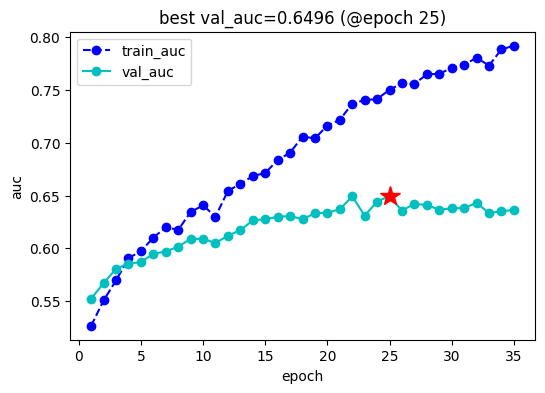

<<<<<< val_auc without improvement in 10 epoch,early stopping >>>>>> 



In [57]:
dfhistory = model.fit(train_data = dl_train,
    val_data = dl_val,
    epochs=100,
    ckpt_path='checkpoint',
    patience=10,
    monitor='val_auc',
    mode='max',
    plot=True,
    cpu=True
)


### 4，评估模型

In [58]:
model.evaluate(dl_val)

100%|█████████████████████████████████| 10/10 [00:00<00:00, 53.85it/s, val_auc=0.65, val_loss=0.709]


{'val_loss': 0.7085483193397522, 'val_auc': 0.6495699286460876}

### 5，使用模型

In [62]:
from sklearn.metrics import roc_auc_score
model.eval()
dl_val = model.accelerator.prepare(dl_val)
with torch.no_grad():
    result = torch.cat([model.forward(t)[0] for t in dl_val])

preds = F.sigmoid(result)
labels = torch.cat([x['label'] for x in dl_val])

val_auc = roc_auc_score(labels.numpy(),preds.numpy())
print(val_auc)

0.6495558111992674


### 6，保存模型

In [63]:
torch.save(model.net.state_dict(),"best_dien.pt")
net_clone = create_net()
net_clone.load_state_dict(torch.load("best_dien.pt"))

<All keys matched successfully>

In [64]:
net_clone.eval()
labels = torch.tensor([x["label"] for x in ds_val])
preds = torch.cat([net_clone(x)[0].data for x in dl_val]) 
val_auc = roc_auc_score(labels.cpu().numpy(),preds.cpu().numpy())
print(val_auc)

0.6495558111992674


**如果本书对你有所帮助，想鼓励一下作者，记得给本项目加一颗星星star⭐️，并分享给你的朋友们喔😊!** 

如果对本书内容理解上有需要进一步和作者交流的地方，欢迎在公众号"算法美食屋"下留言。作者时间和精力有限，会酌情予以回复。

也可以在公众号后台回复关键字：**加群**，加入读者交流群和大家讨论。

![算法美食屋logo.png](https://tva1.sinaimg.cn/large/e6c9d24egy1h41m2zugguj20k00b9q46.jpg)
